# First steps

### Imports

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

### Download data from Kaggle

We use Kaggle's Public API (https://www.kaggle.com/docs/api). See also https://www.youtube.com/watch?v=gkEbaMgvLs8

In [2]:
!kaggle datasets download jerzydziewierz/bee-vs-wasp

bee-vs-wasp.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -q -o bee-vs-wasp.zip 

In [4]:
!ls

Bee-vs-wasp-with-PyTorch.ipynb bee-vs-wasp.zip
README.md                      kaggle_bee_vs_wasp


# Data Processing

#### Import the labels

In [5]:
import csv
labels_path = "kaggle_bee_vs_wasp/labels.csv"
labels_numpy = np.loadtxt(labels_path, dtype=np.str, delimiter=",", skiprows=1)
col_list = next(csv.reader(open(labels_path), delimiter=','))
type(labels_numpy), labels_numpy.shape, col_list

(numpy.ndarray,
 (11421, 10),
 ['id',
  'path',
  'is_bee',
  'is_wasp',
  'is_otherinsect',
  'is_other',
  'photo_quality',
  'is_validation',
  'is_final_validation',
  'label'])

In [6]:
class_names = ['bee','wasp','otherinsect','other']
num_classes = 4
classes_map = {'bee': 0, 'wasp': 1, 'otherinsect': 2,  'other':3 }

In [7]:
## Convert label indices to an integer

def retrieve_label(idx):
    label_one_hot = labels_numpy[idx][2:6].astype('int32')
    assert label_one_hot.sum() == 1 and all(label_one_hot >= 0)
    return sum([label_one_hot[j]*classes_map[class_names[j]] for j in range(4)]) 

#### Collect indices

Collect the indices of the high-quality training examples, the validation examples, and the final validation examples

In [8]:
train_ids = []
val_ids = []
final_val_ids = []

for i in range(len(labels_numpy)):
    if labels_numpy[i][6] == '1' and labels_numpy[i][7] == '0' and labels_numpy[i][8] == '0':
        train_ids.append(i)
        
    elif labels_numpy[i][7] == '1':
        val_ids.append(i)
        
    elif labels_numpy[i][8] == '1':
        final_val_ids.append(i)
        
num_train = len(train_ids)
num_val = len(val_ids)
num_final_val = len(final_val_ids)
print(f"Number of training images: %d" % num_train)
print(f"Number of validation images: %d" % num_val)
print(f"Number of final validation images: %d" % num_final_val)

#train_ids[:20]

Number of training images: 4908
Number of validation images: 1719
Number of final validation images: 1763


#### Import the images

Process the images and put them into the data_train tensor

In [9]:
from torchvision import transforms

preprocess = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

In [10]:
from PIL import Image
import os
import tqdm

In [11]:
# This may take around 20 seconds
error_counter = 0
data_train = []

for idx in tqdm.tqdm(train_ids):
    folder, filename = labels_numpy[idx][1].split('\\')
    file_path = 'kaggle_bee_vs_wasp/' + folder + '/' + filename 
    img = Image.open(file_path)
    img_t = preprocess(img)
    
    if img_t.shape[0] != 3:
        error_counter += 1
    else:
        data_train.append((img_t, retrieve_label(idx)))
        
print("Number of images skipped due to an error: ", error_counter)

100%|██████████| 4908/4908 [00:17<00:00, 287.54it/s]

Number of images skipped due to an error:  2


In [12]:
# This may take up to 15 seconds
data_val = []

for idx in tqdm.tqdm(val_ids):
    folder, filename = labels_numpy[idx][1].split('\\')
    file_path = 'kaggle_bee_vs_wasp/' + folder + '/' + filename 
    img = Image.open(file_path)
    img_t = preprocess(img)
    data_val.append((img_t, retrieve_label(idx)))

100%|██████████| 1719/1719 [00:12<00:00, 136.77it/s]


In [13]:
# This may take up to 15 seconds
data_final_val = []

for idx in tqdm.tqdm(final_val_ids):
    folder, filename = labels_numpy[idx][1].split('\\')
    file_path = 'kaggle_bee_vs_wasp/' + folder + '/' + filename 
    img = Image.open(file_path)
    img_t = preprocess(img)
    data_final_val.append((img_t, retrieve_label(idx)))

100%|██████████| 1763/1763 [00:13<00:00, 132.18it/s]


#### Normalize the data

In [14]:
type(data_train), data_train[578][0].shape

(list, torch.Size([3, 256, 256]))

In [15]:
#imgs = torch.stack([img_t for img_t, _ in data_train], dim=3)
#imgs.shape

In [16]:
#imgs.view(3, -1).mean(dim=1)  # <1>

In [17]:
#imgs.view(3, -1).std(dim=1)

In [18]:
## This may take about 30-40 seconds

normalization = transforms.Normalize((0.5226, 0.5086, 0.3374), (0.2613, 0.2464, 0.2691))
data_train_transformed = []

for img, label in tqdm.tqdm(data_train):
    data_train_transformed.append((normalization(img), label))

100%|██████████| 4906/4906 [00:34<00:00, 140.68it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


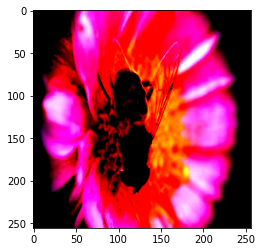

In [19]:
img_t, _ = data_train_transformed[0]
plt.imshow(img_t.permute(1,2, 0))
plt.show()

#### Quick sanity check that the normalization works!

In [20]:
random_indices = torch.rand(300)*num_train
data_sample_normalized = normalization(torch.stack([data_train[int(i)][0] for i in random_indices]))

sample_means = torch.mean(data_sample_normalized, [0,2,3], keepdim=True).reshape(3,)
sample_stds = torch.std(data_sample_normalized, [0,2,3], keepdim=True).reshape(3,)

torch.round(10000*sample_means)/10000, torch.round(10000*sample_stds)/10000

(tensor([0.0535, 0.0425, 0.0054]), tensor([1.0239, 1.0213, 1.0273]))

# Convolutional neural network

In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [22]:
type(data_train), data_train[578][0].shape

(list, torch.Size([3, 256, 256]))

In [23]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 64 * 64, 8)
        self.fc2 = nn.Linear(8, 4)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 4 * 64 * 64)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [24]:
ex_net = Net()

numel_list = [p.numel() for p in ex_net.parameters()]
sum(numel_list), numel_list

(131632, [216, 8, 288, 4, 131072, 8, 32, 4])

In [25]:
ex_img = data_train[578][0].unsqueeze(0)
print(ex_img.shape)
ex_net(ex_img)

torch.Size([1, 3, 256, 256])


tensor([[ 0.4156,  0.3542,  0.1754, -0.0687]], grad_fn=<AddmmBackward>)

### Next steps:

In [26]:
## Check this:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=8, shuffle=True) 
val_loader = torch.utils.data.DataLoader(data_val, batch_size=8, shuffle=True) 

In [27]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1): 
        loss_train = 0.0
        for imgs, labels in tqdm.tqdm(train_loader): 
            
            outputs = model(imgs) 
            loss = loss_fn(outputs, labels) 

            optimizer.zero_grad() 
            loss.backward()
            optimizer.step() 

            loss_train += loss.item() 

        print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))  # <10>
            
#         if epoch == 1 or epoch % 10 == 0:
#             print('{} Epoch {}, Training loss {}'.format(
#                 datetime.datetime.now(), epoch,
#                 loss_train / len(train_loader)))  # <10>

In [28]:
model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 20,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

  0%|          | 1/614 [00:00<02:00,  5.08it/s]

2021-06-28 14:52:11.451678 Epoch 1, Training loss 1.0865748669309025


  0%|          | 2/614 [00:00<00:40, 15.30it/s]

2021-06-28 14:52:48.527298 Epoch 2, Training loss 0.971307198077149


  0%|          | 2/614 [00:00<00:41, 14.80it/s]

2021-06-28 14:53:24.032425 Epoch 3, Training loss 0.9290770652433948


  0%|          | 2/614 [00:00<00:43, 14.20it/s]

2021-06-28 14:53:59.180716 Epoch 4, Training loss 0.9035552308594365


  0%|          | 2/614 [00:00<00:38, 15.69it/s]

2021-06-28 14:54:34.966603 Epoch 5, Training loss 0.8764823838243267


  0%|          | 2/614 [00:00<00:38, 15.96it/s]

2021-06-28 14:55:09.989566 Epoch 6, Training loss 0.8612210146281929


  0%|          | 2/614 [00:00<00:41, 14.85it/s]

2021-06-28 14:55:45.044958 Epoch 7, Training loss 0.8518356880361172


  0%|          | 2/614 [00:00<00:38, 15.74it/s]

2021-06-28 14:56:20.631889 Epoch 8, Training loss 0.8563647555605984


  0%|          | 2/614 [00:00<00:40, 15.13it/s]

2021-06-28 14:56:56.482062 Epoch 9, Training loss 0.8590750649134576


  0%|          | 2/614 [00:00<00:48, 12.60it/s]

2021-06-28 14:57:34.951127 Epoch 10, Training loss 0.8334981346144933


  0%|          | 2/614 [00:00<00:40, 14.98it/s]

2021-06-28 14:58:14.166091 Epoch 11, Training loss 0.8083393820333947


  0%|          | 2/614 [00:00<00:39, 15.48it/s]

2021-06-28 14:58:49.454973 Epoch 12, Training loss 0.8010808931062975


  0%|          | 2/614 [00:00<00:40, 15.17it/s]

2021-06-28 14:59:25.398647 Epoch 13, Training loss 0.798906147625625


  0%|          | 2/614 [00:00<00:40, 15.10it/s]

2021-06-28 15:00:05.331105 Epoch 14, Training loss 0.7902743038554533


  0%|          | 2/614 [00:00<00:39, 15.62it/s]

2021-06-28 15:00:42.370233 Epoch 15, Training loss 0.8024923998486335


  0%|          | 2/614 [00:00<00:40, 14.99it/s]

2021-06-28 15:01:18.357868 Epoch 16, Training loss 0.7775017897498335


  0%|          | 2/614 [00:00<00:41, 14.74it/s]

2021-06-28 15:01:54.132884 Epoch 17, Training loss 0.7559126038893038


  0%|          | 2/614 [00:00<00:41, 14.60it/s]

2021-06-28 15:02:31.185481 Epoch 18, Training loss 0.7745122325391257


  0%|          | 2/614 [00:00<00:42, 14.53it/s]

2021-06-28 15:03:08.659071 Epoch 19, Training loss 0.7535879430922312


100%|██████████| 614/614 [00:37<00:00, 16.51it/s]

2021-06-28 15:03:45.849418 Epoch 20, Training loss 0.7351143734365799


In [30]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in tqdm.tqdm(loader):
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

  1%|          | 2/215 [00:00<00:17, 12.27it/s]

Accuracy train: 0.72


100%|██████████| 215/215 [00:13<00:00, 16.21it/s]

Accuracy val: 0.57
